## Lake Zug CTD + microCTD Report (13.2.2026)

In [1]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260213'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

### CTD

In [3]:
def extract_profile_locations(dpath_L1, oom=True):
    profile_locs = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # Swiss coordinates
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)

        # bathymetry
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()
        
        profile_locs.append({
            'name': ds.attrs['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(profile_locs).sort_values('ysc', ascending=False).reset_index(drop=True), bathy

def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()

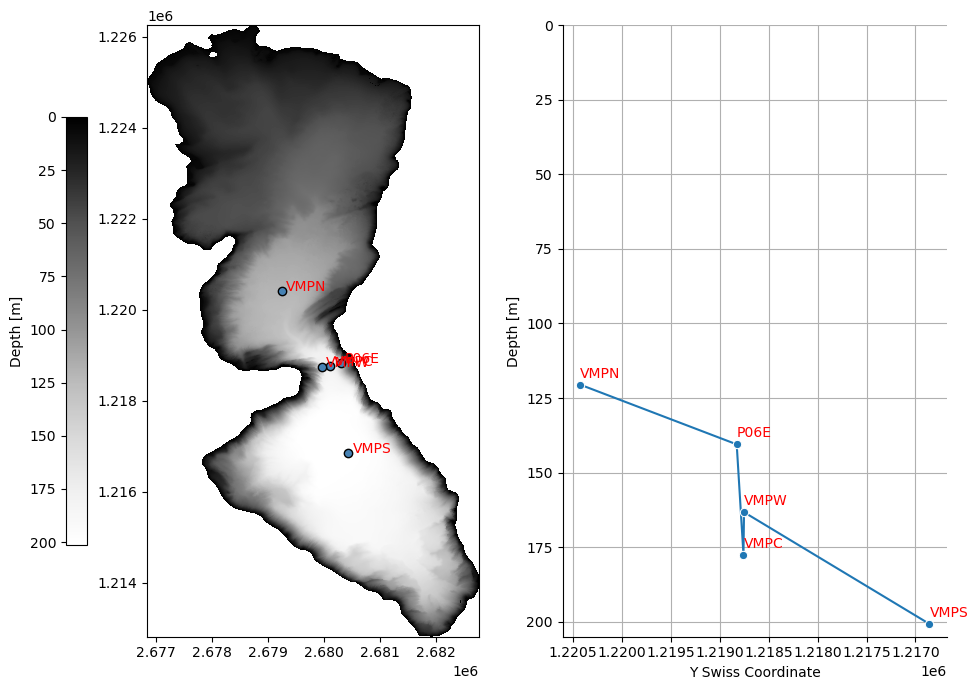

In [4]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [5]:
def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        else:
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        if var == 'DO_mg':    # convert to umol/L
            vals *= (1000/32)

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)

def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'
    elif var == 'rho':
        color = 'orange'
    elif var == 'Turb':
        color = 'brown'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        fig.supxlabel('Density [kg/m^3]')
    elif var == 'Turb':
        fig.supxlabel('Turbidity [FTU]')

    plt.tight_layout(w_pad=0.5)
    plt.show()

In [6]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')
rho_data = extract_data_vars(dpath_L1, 'rho')

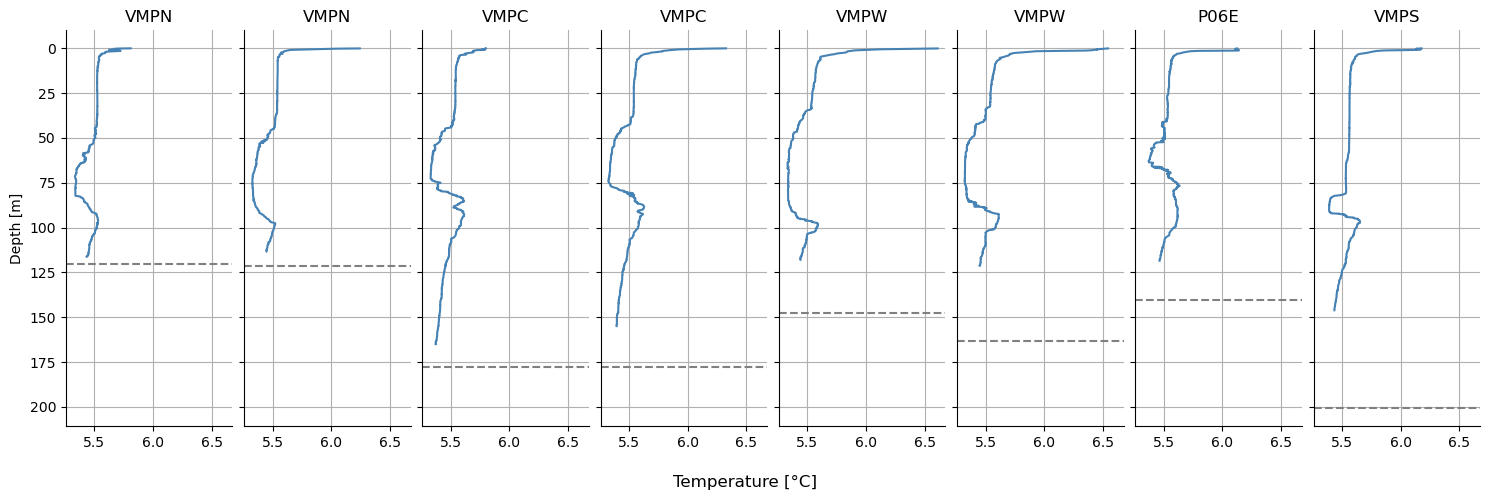

In [7]:
plot_profiles_transect(temp_data, 'Temp')

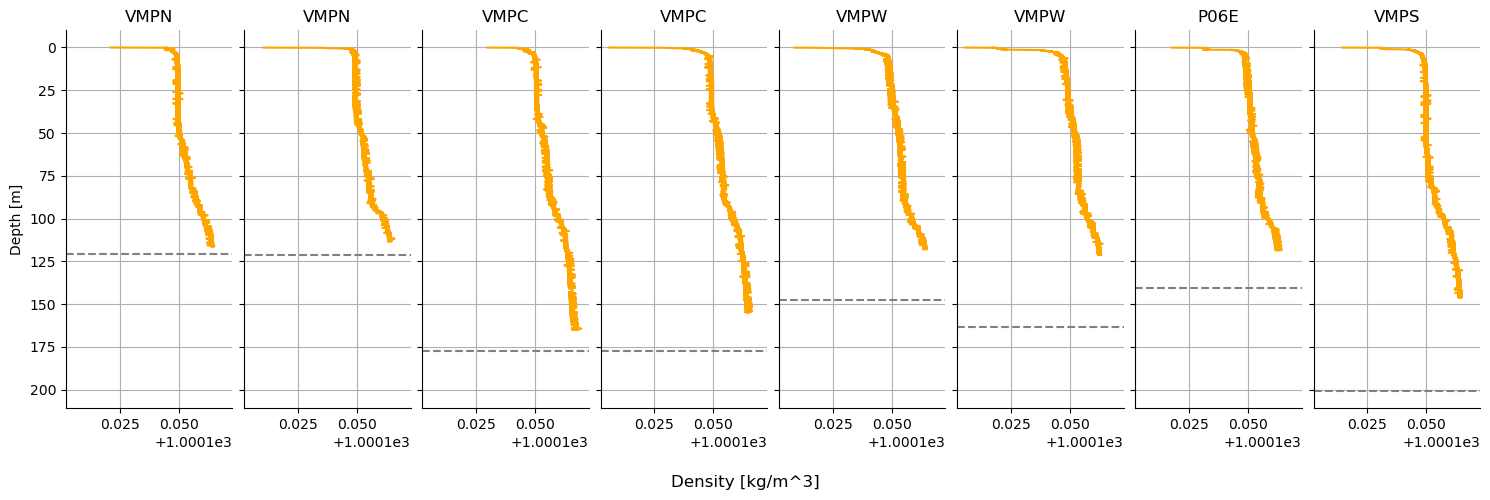

In [8]:
plot_profiles_transect(rho_data, 'rho')

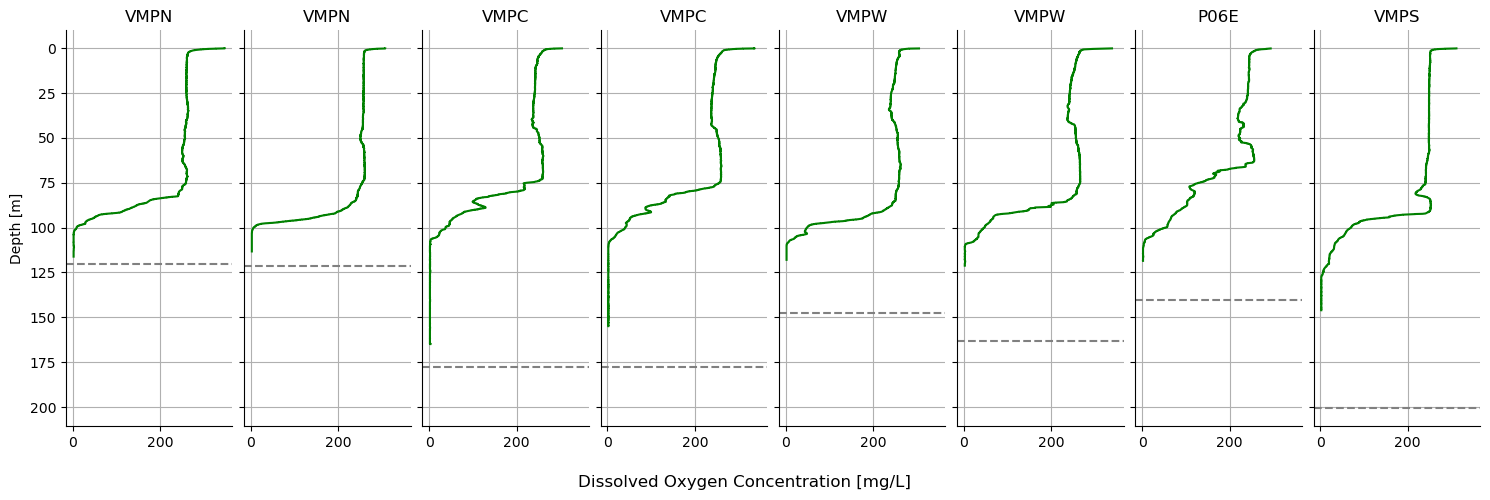

In [9]:
plot_profiles_transect(do_data, 'DO_mg')

In [10]:
def plot_profiles_overlay(data, var, locs):
    df = data[data['name'].isin(locs)]

    fig, ax = plt.subplots(figsize=(7, 5))

    for t, dat in df.groupby('time', sort=False):
        ax.plot(dat[var], dat['depth'], label=f"{dat['name'].unique()[0]} | {t}")

    if var == 'Temp':
        ax.set_xlabel('Temperature [°C]')
    elif var == 'DO_mg':
        ax.set_xlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        ax.set_xlabel('Density [kg/m^3]')
    ax.set_ylabel('Depth [m]')
    ax.set_title(f'Profile Locations {locs}')

    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.legend()
    ax.invert_yaxis()

    plt.show()

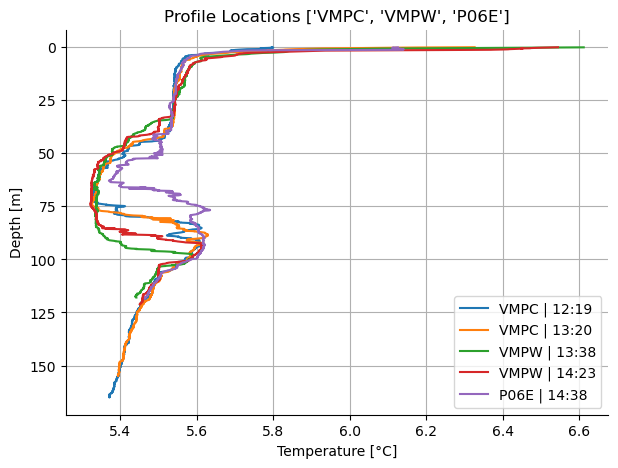

In [11]:
plot_profiles_overlay(temp_data, 'Temp', ["VMPC", "VMPW", "P06E"])

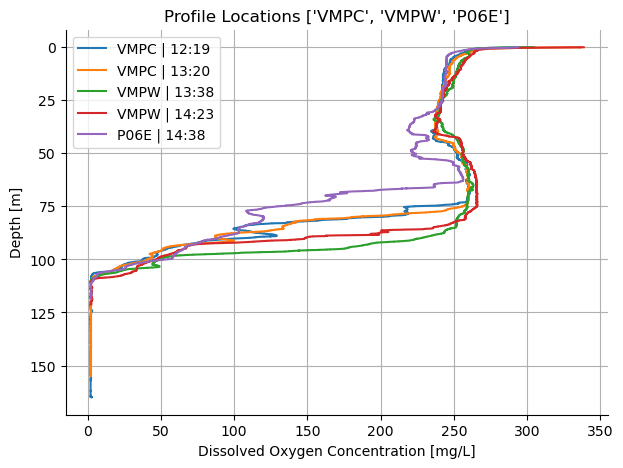

In [13]:
plot_profiles_overlay(do_data, 'DO_mg', ["VMPC", "VMPW", "P06E"])

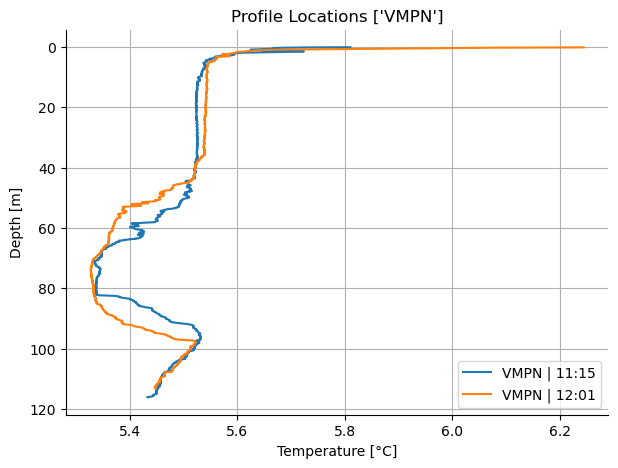

In [12]:
plot_profiles_overlay(temp_data, 'Temp', ["VMPN"])

In [14]:
def calculate_transect_min_do(dpath_L1):
    # transect minimum
    min_do = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        do = ds['DO_mg'][mask]
        min_do.append(do.min().item())

    return min(min_do)


def calculate_anoxia(dpath_L1, err=0.2, oom=True):
    min_do = calculate_transect_min_do(dpath_L1)

    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        depth = ds['depth'][mask]
        do = ds['DO_mg'][mask]

        try:
            idx = np.where(do <= min_do + err)[0][0]
            z = depth[idx].item()
        except IndexError:
            z = np.nan

        data.append({
            'anoxic_z': z,
            'name': name,
            'time': time,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)


def plot_anoxia(data, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.lineplot(df, x='ysc', y='anoxic_z', color='limegreen', marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_title('Anoxic Zone')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

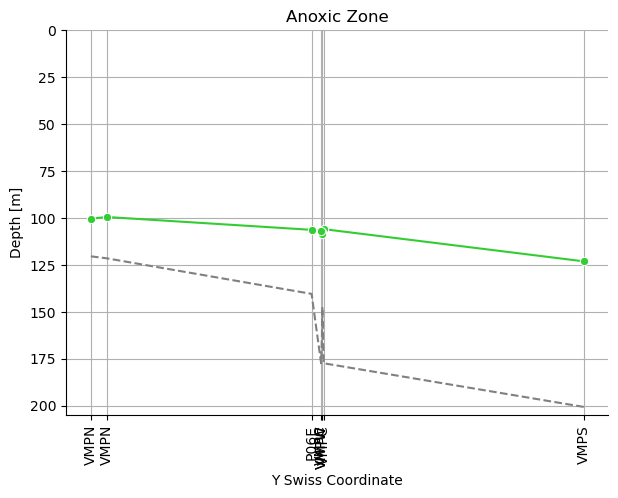

In [15]:
anoxic_data = calculate_anoxia(dpath_L1)
plot_anoxia(anoxic_data)